In [22]:
# OPTIONAL: Load the "autoreload" extension so that code can change
%reload_ext autoreload

# OPTIONAL: always reload modules so that as you change code in src, it gets loaded
%autoreload 2

import sys
sys.path.append('../src')

import cv2
from IPython.display import display_html
import matplotlib.pyplot as plt
from metadata import metadata
from multiprocessing import Pool, cpu_count
import numpy as np
import ome_types
import os
import pandas as pd
from pathlib import Path
import re
# from sklearn.mixture import GaussianMixture
import tifffile as tiff
from tqdm import tqdm

from utils import list_subdir_filter as lsd


md = metadata() 

def get_id(f):
    return re.sub('^.*A40.([0-9]+).*$', '\\1', f)


figures_dir = '/projects/ag-bozek/lunaphore/reports/figures'
binary_dir = '/projects/ag-bozek/lunaphore/data/interim'

In [3]:
all_img_files = lsd(md.folders['images'], True, '.tif')


In [ ]:
for img_file in tqdm(all_img_files):
    img_id = get_id(img_file)
    img = tiff.imread(img_file, key=5)
    low_thr = np.quantile(img[100:-100, 100:-100], 0.002)
    hi_thr = np.quantile(img[100:-100, 100:-100], 0.998)
    img = (np.clip(img, low_thr, np.Inf) - low_thr).astype('uint16')
    threshold, binarized = cv2.threshold(img, 0, 65535, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    
    np.save(os.path.join(binary_dir, f'gfp_positive.np'), binarized.astype('bool'))
    
    vals = img.flatten()
    fig, ax = plt.subplots(1, 1, figsize=(6,4))
    _p = ax.hist(vals[vals<hi_thr], bins=125)
    ax.set_yticks([])
    ax.vlines(x=threshold, ymin=0, ymax=_p[0].max(), color='gold')
    ax.set_title(f'{img_id}')
    ax.text(
        s=f'hi = {int(hi_thr)}\nthr = {int(threshold)}\nlow = {int(low_thr)}', 
        x=0.95, 
        y= 0.95, 
        ha='right', 
        va='top',
        transform=ax.transAxes,
        family=plt.rcParams["font.monospace"][0],
    )
    plt.savefig(os.path.join(figures_dir, f'gfp_thresholding_{img_id}.pdf'))
    plt.close()
    
    plt.imshow(binarized[::15, ::15])
    plt.axis('off')
    plt.savefig(os.path.join(figures_dir, f'gfp_binarized_{img_id}.png'))
    plt.close()

In [ ]:
md.markers§dd

In [ ]:
list(md.markers)[5]
# list(md.markers)[9]


In [ ]:
md.marker_channels

In [ ]:
%%time
for img_file in all_img_files[:1]:
    
    cy = tiff.imread(img_file, key=1)
    gfp = tiff.imread(img_file, key=5)
    slug = tiff.imread(img_file, key=9)

    sub_gfp = gfp.astype('int32') - cy
    sub_slug = slug.astype('int32') - cy
    

In [ ]:
%%time
subtraction = slug.astype('int32') - cy

In [ ]:
np.sum(subtraction < -75) / len(subtraction.flatten())

In [ ]:
np.quantile(np.clip(subtraction, 0, np.Inf), 0.95)

In [ ]:
np.quantile(subtraction, 0.95)

In [ ]:
plt.figure(figsize=(10,4))
p = plt.hist(subtraction.flatten()[::4], log=True, bins=150, color='green')
plt.title(f'{img_id} - post-AF correction')
plt.vlines(x=0, ymin=0.1, ymax=p[0].max()*1.02, color='gold')
plt.savefig(os.path.join(md.folders['bg_removed'], f'intensity_dist_AF_correction_{img_id}.png'))
plt.xlim(-65535, 65535)


In [ ]:
p[0].max()

In [ ]:
np.max(sub_gfp)

In [ ]:
65535 >> 8

In [27]:
def subtract_AF(signal, af, img_id, marker_name, clipmax=20000):

    clean = signal.astype('int32') - af
    
    plt.figure(figsize=(10,4))
    p = plt.hist(clean.flatten()[::4], log=True, bins=150, color='green')
    plt.title(f'{img_id} ({marker_name}) post-AF correction')
    plt.vlines(x=0, ymin=0.1, ymax=p[0].max()*1.02, color='gold')
    plt.xlim(-65535, 65535)

    plt.savefig(os.path.join(md.folders['bg_removed'], f'intensity_dist_AF_correction_{img_id}.png'))
    plt.close()

    
    aaa = [
        np.clip(clean[::8,::8], 0, clipmax)/clipmax, 
        np.clip(af[::8,::8], 0, clipmax)/clipmax, 
        np.clip(clean[::8,::8], 0, clipmax)/clipmax
    ] 

    aaa = np.moveaxis(aaa, 0, -1)

    plt.figure(figsize=(6,6))
    plt.imshow(aaa)
    plt.axis('off')
    plt.title(f'{img_id}: AF/{marker_name}')
    plt.savefig(os.path.join(md.folders['bg_removed'], f'AF_correction_{img_id}_{marker_name}.png'), transparent=True)
    plt.close()

    np.save(
        os.path.join(md.folders['bg_removed'], f'clean_{marker_name}_{img_id}.npy'),
        (np.clip(clean, 0, np.Inf).astype('uint16') >> 8).astype('uint8')
    )


def do_the_cleaning(img_file):
    img_id = get_id(img_file)
    print(img_id)

    markers = list(md.markers)

    existing = sum([os.path.exists(os.path.join(md.folders['bg_removed'], f'clean_{marker}_{img_id}.npy')) for marker in markers])
    if existing == 9:
        print(f'{img_id} already processed, skipping')
        return None
    
    bg = tiff.imread(img_file, key=1)
    
    for i in range(3, len(md.markers), 2):
        marker = markers[i]
        print(marker)
        signal = tiff.imread(img_file, key=i)
        subtract_AF(signal, bg, img_id, marker_name=marker)

    bg = tiff.imread(img_file, key=2)
    for i in range(4, len(md.markers), 2):
        marker = markers[i]
        print(marker)
        signal = tiff.imread(img_file, key=i)
        subtract_AF(signal, bg, img_id, marker_name=marker)


def safe_cleaning(img_file):
    img_id = get_id(img_file)
    print(img_id)
    try:
        do_the_cleaning(img_file)
    except:
        print(f'error with {img_id}')

In [28]:
md.markers

{'DAPI': 'DAPI',
 'cy5': 'Cy5 AF',
 'tritc': 'TRITC AF',
 'c-myc': 'c-Myc (Y69)',
 'ecad': 'E-Cadherin 36/E',
 'gfp': 'GFP D5.1',
 'vim': 'Vimentin V9',
 'ccasp': 'Cleaved Caspase3 D175',
 'ki67': 'Ki67 MIB-1',
 'slug': 'SLUG C19G7',
 'ck': 'CK AE1/AE3',
 'fibro': 'Fibronectin E5H6X'}

In [33]:
?pool.map_async

Signature:
pool.map_async(
    func,
    iterable,
    chunksize=None,
    callback=None,
    error_callback=None,
)
Docstring: Asynchronous version of `map()` method.
File:      /projects/ag-bozek/stefano/pytorch_env/lib/python3.9/multiprocessing/pool.py
Type:      method

In [31]:
cpu_count()

40

In [35]:
with Pool(processes=cpu_count()) as pool:
    pool.apply_async(safe_cleaning, all_img_files)

  0%|                                                                                                                                                                                                                                                                                    | 0/34 [00:00<?, ?it/s]

2338
2338
2338 already processed, skipping
2305
2305
2305 already processed, skipping
2268
2268
2268 already processed, skipping
2311
2311
2311 already processed, skipping
2314
2314
2314 already processed, skipping
2418
2418
2418 already processed, skipping
2427
2427
2427 already processed, skipping
2300
2300
2300 already processed, skipping
2407
2407
c-myc


 26%|██████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                     | 9/34 [00:14<00:40,  1.61s/it]

error with 2407
2255
2255
2255 already processed, skipping
2406
2406
2406 already processed, skipping
2416
2416
2416 already processed, skipping
2419
2419
2419 already processed, skipping
2337
2337
2337 already processed, skipping
2312
2312
2312 already processed, skipping
2404
2404
2404 already processed, skipping
2256
2256
2256 already processed, skipping
2408
2408
c-myc
gfp
ccasp
slug
fibro
ecad
vim
ki67
ck


 53%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                             | 18/34 [06:32<06:45, 25.35s/it]

2430
2430
c-myc
gfp
ccasp
slug
fibro
ecad
vim
ki67
ck


 56%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                     | 19/34 [13:12<14:19, 57.33s/it]

2304
2304
c-myc
gfp
ccasp
slug
fibro
ecad
vim
ki67
ck


 59%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                              | 20/34 [20:07<22:27, 96.25s/it]

2339
2339
c-myc
gfp
ccasp
slug
fibro
ecad
vim
ki67
ck


 62%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                     | 21/34 [27:24<30:46, 142.06s/it]

2432
2432
c-myc
gfp
ccasp
slug
fibro
ecad
vim
ki67
ck


 65%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                              | 22/34 [34:45<38:03, 190.26s/it]

2393
2393
c-myc
gfp
ccasp
slug
fibro
ecad
vim
ki67
ck


 68%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                      | 23/34 [41:39<42:33, 232.13s/it]

2417
2417
c-myc
gfp
ccasp
slug
fibro
ecad
vim
ki67
ck


 71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                              | 24/34 [47:11<42:12, 253.26s/it]

2420
2420
c-myc
gfp
ccasp
slug
fibro
ecad
vim
ki67
ck


 74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                      | 25/34 [52:46<40:48, 272.07s/it]

2429
2429
c-myc
gfp
ccasp
slug
fibro
ecad
vim
ki67
ck


 76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                              | 26/34 [58:08<37:56, 284.52s/it]

2294
2294


 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                      | 27/34 [58:16<24:43, 211.93s/it]

c-myc
error with 2294
2403
2403
c-myc
gfp
ccasp
slug
fibro
ecad
vim
ki67
ck


 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                              | 28/34 [1:03:39<24:13, 242.22s/it]

2397
2397
c-myc
gfp
ccasp
slug
fibro
ecad
vim
ki67
ck


 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                      | 29/34 [1:09:00<22:01, 264.31s/it]

2405
2405
c-myc
gfp
ccasp
slug
fibro
ecad
vim
ki67
ck


 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                               | 30/34 [1:14:33<18:56, 284.14s/it]

2426
2426
c-myc
gfp
ccasp
slug
fibro
ecad
vim
ki67
ck


 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                       | 31/34 [1:20:04<14:53, 297.68s/it]

2294
2294
c-myc
gfp
ccasp
slug
fibro
ecad
vim
ki67
ck


 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍               | 32/34 [1:25:31<10:12, 306.30s/it]

2429
2429
2429 already processed, skipping
2303
2303
c-myc
gfp
ccasp
slug
fibro
ecad
vim
ki67
ck


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [1:30:59<00:00, 160.57s/it]


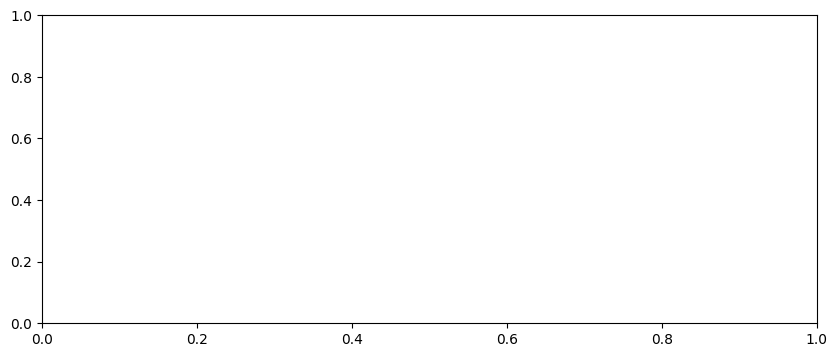

In [37]:
for img_file in tqdm(all_img_files):
    safe_cleaning(img_file)

In [ ]:
plt.imshow(np.moveaxis(aaa, 0, -1))
plt.axis('off')

In [ ]:
# titles = ('gfp', 'gfp (clean)', 'slug', 'slug (clean)')
# fig, axes = plt.subplots(2,3,figsize=(8,8))
# for i, ax in enumerate(axes.ravel()):
#     ax.axis('off')
#     ax.set_title(titles[i])
#     axes[0,0].imshow(gfp[::8,::8], vmin=0, vmax=20000, cmap='gray')
#     axes[0,1].imshow(sub_gfp[::8,::8], vmin=0, vmax=20000, cmap='gray')
#     axes[1,0].imshow(slug[::8,::8], vmin=0, vmax=20000, cmap='gray')
#     axes[1,1].imshow(sub_slug[::8,::8], vmin=0, vmax=20000, cmap='gray')

# plt.tight_layout()

In [ ]:
cy.astype('int32').max()

In [ ]:
plt.imshow(np.clip(subtraction, 0, np.Inf))

In [ ]:
plt.imshow(slug)

In [ ]:
md.markers

In [ ]:
def whole_cleaning(img_file):
    img_id = get_id(img_file)

    markers = md.markers
    cy = tiff.imread(img_file, key=1)
    for i in range(3, len(md.markers), 2):
        marker = markers[i]
        signal = tiff.imread(img_file, key=i)

    
    clean_gfp  = subtract_AF(gfp,  cy, img_id, marker_name='GFP')
    clean_slug = subtract_AF(slug, cy, img_id, marker_name='slug'))